# Customer Lifetime Value of Online Retail

In [ ]:
import pandas as pd
import datetime as dt
import calendar
import numpy as np
from decimal import Decimal 
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

## Dataset Information

In [ ]:
df = pd.read_csv('OnlineRetail.csv')
df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2011 12:50,4.15,12680.0,France


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Check missing value in data

df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#check percentage of missing value in data
df_null=round(df.isnull().sum()/len(df)*100,2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

Based on the output above we know that the percentage of missing value is counted on `Description` (0.27%) and `CustomerID` (24.93%) columns.

## Data Preprocessing

In [ ]:
# # Remove duplicated data records
# df.dropna(inplace=True)

# #check percentage of missing value in data
# df_null=round(df.isnull().sum()/len(df)*100)
# df_null

By doing this we want to drop NaN values that contains in the dataset.

In [ ]:
# Remove 135080 rows missing values of CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Keeping the records of non negative quantity
df = df[(df['Quantity']>0)]

# Add Total Sales column into dataframe
df['UnitPrice'] = df['UnitPrice'].apply(Decimal)
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
df['TotalSales'] = df['TotalSales'].apply(Decimal) 

# Format date for InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H:%M')

# Add Month and Year column
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

# Set up data types 
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['CustomerID'] = df['CustomerID'].astype('str')
df['Description'] = df['Description'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df['Country'] = df['Country'].astype('str')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  object        
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
 8   TotalSales   397924 non-null  object        
 9   Month        397924 non-null  int32         
 10  Year         397924 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(7)
memory usage: 33.4+ MB


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  object        
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
 8   TotalSales   397924 non-null  object        
 9   Month        397924 non-null  int32         
 10  Year         397924 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(7)
memory usage: 33.4+ MB


In [ ]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSales     0
Month          0
Year           0
dtype: int64

In [ ]:
data = df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  object        
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
 8   TotalSales   397924 non-null  object        
 9   Month        397924 non-null  int32         
 10  Year         397924 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(7)
memory usage: 33.4+ MB


## Analysis - Unit prices of the items

In [ ]:
# Finding row with maximum and minimum unit price
max_unit_price_row, min_unit_price_row = data.loc[data['UnitPrice'].idxmax()], data.loc[data['UnitPrice'].idxmin()]

# Show description and maximum unit price
max_description, max_UnitPrice = max_unit_price_row['Description'], max_unit_price_row['UnitPrice']

# Show description and minimum unit price
min_description, min_UnitPrice = min_unit_price_row['Description'], min_unit_price_row['UnitPrice']

print(f"""
Maximum unit price:
Unit Name: {max_description}
Unit Price: {max_UnitPrice}

Minimum unit price:
Unit Name: {min_description}
Unit Price: {min_UnitPrice}
""")


Maximum unit price:
Unit Name: POSTAGE
Unit Price: 8142.75

Minimum unit price:
Unit Name: ROUND CAKE TIN VINTAGE GREEN
Unit Price: 0



## Analysis of Transaction Count, Total Revenue, and Average Price of each Country

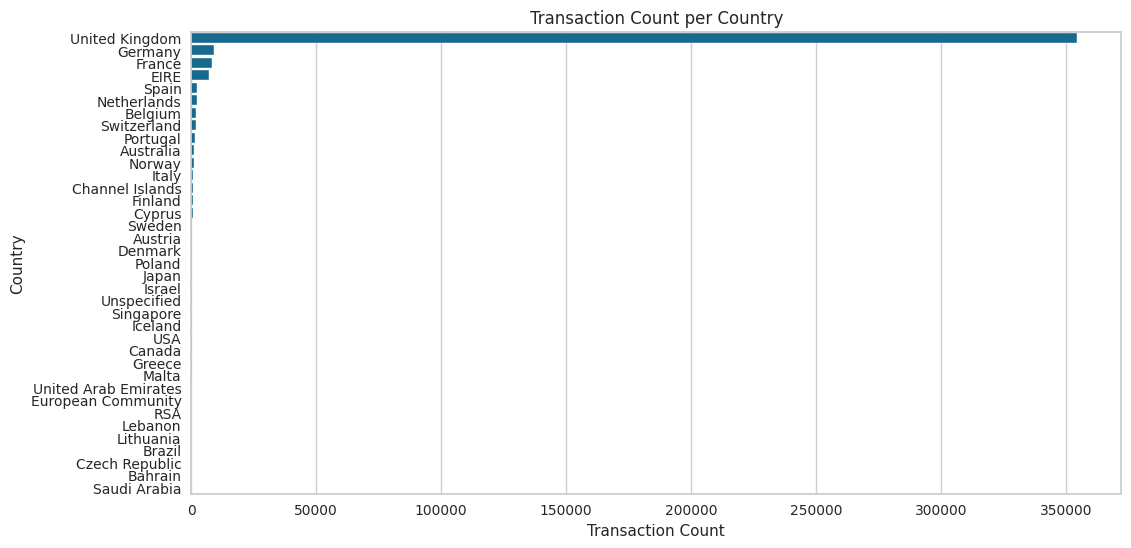

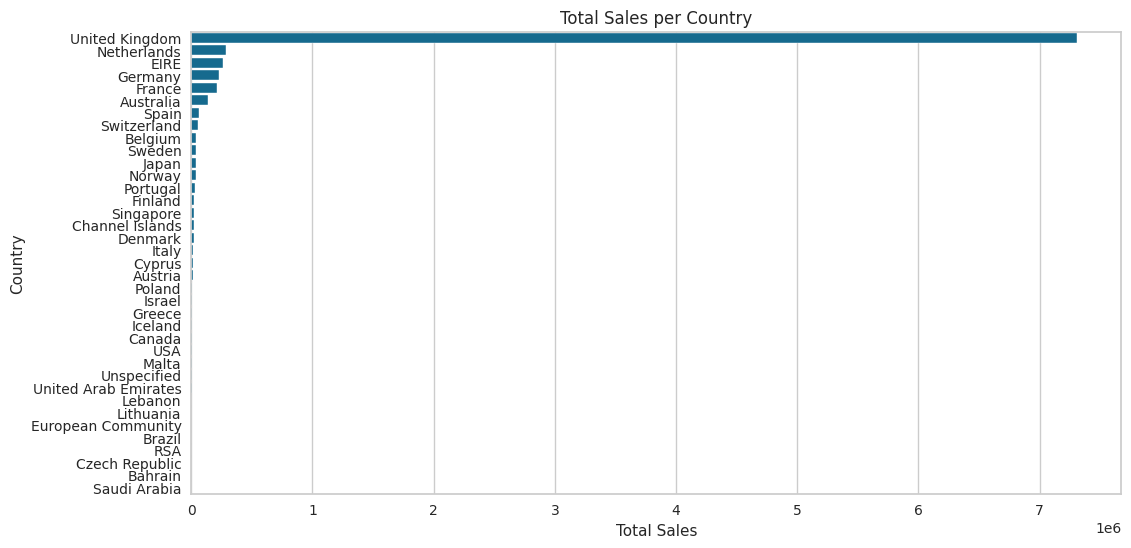

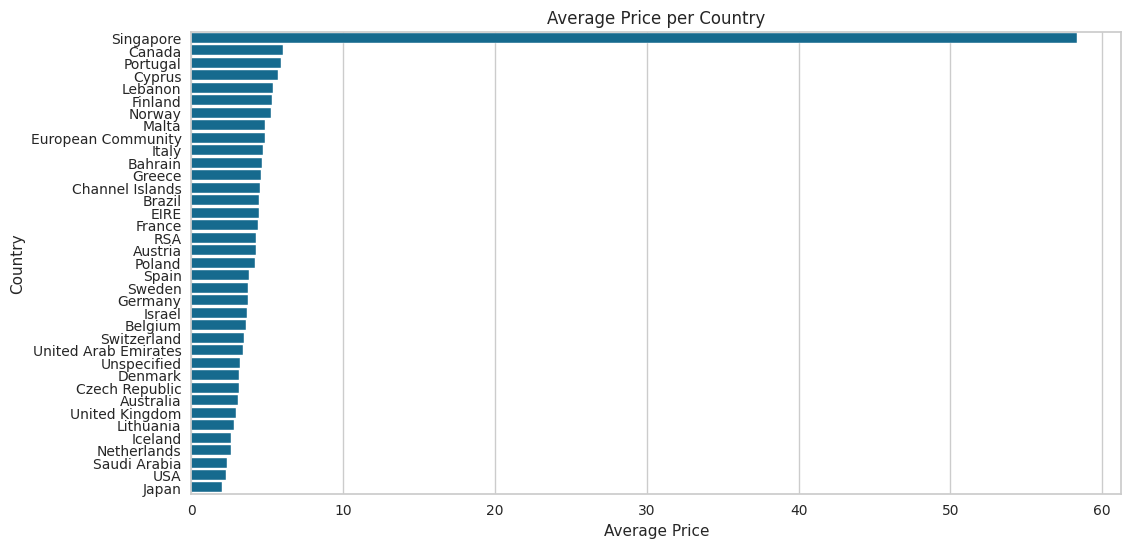

In [ ]:
# Set the style of seaborn plots
sns.set_style("whitegrid")

# Grouping the data based on the 'Country' column and calculating the transaction count per country
transaction_count = data.groupby('Country')['InvoiceNo'].count()

# Calculating total revenue per country
total_revenue = data.groupby('Country')['TotalSales'].sum()

# Calculating average price per country
average_price = data.groupby('Country')['UnitPrice'].mean()

summary_table = pd.DataFrame({
    'Country': transaction_count.index,
    'Transaction Count': transaction_count.values,
    'Total Revenue': total_revenue.values,
    'Average Price per Country': average_price
})

# Plotting transaction count per country
plt.figure(figsize=(12, 6))
sns.barplot(x='Transaction Count', y='Country', data=summary_table.sort_values(by='Transaction Count', ascending=False))
plt.title('Transaction Count per Country')
plt.xlabel('Transaction Count')
plt.ylabel('Country')
plt.show()

# Plotting total revenue per country
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Revenue', y='Country', data=summary_table.sort_values(by='Total Revenue', ascending=False))
plt.title('Total Sales per Country')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.show()

# Plotting average price per country
plt.figure(figsize=(12, 6))
sns.barplot(x='Average Price per Country', y='Country', data=summary_table.sort_values(by='Average Price per Country', ascending=False))
plt.title('Average Price per Country')
plt.xlabel('Average Price')
plt.ylabel('Country')
plt.show()

## Analyze repeat customers

In [ ]:
# Calculating the number of repeat customers
repeat_customers = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Customers who have more than one purchase
repeat_customers = repeat_customers[repeat_customers > 1]

# Total repeat purchases and purchase frequency for each customer
repeat_purchase_info = data[data['CustomerID'].isin(repeat_customers.index)].groupby('CustomerID').agg({
    'InvoiceNo': 'count'
}).rename(columns={
    'InvoiceNo': 'Total Purchases'
})
repeat_purchase_info = repeat_purchase_info.sort_values(by='Total Purchases', ascending=False)
# Displaying the analysis results
print("Total repeat customers:", len(repeat_customers))
print("Repeat purchase information:")
repeat_purchase_info


Total repeat customers: 2845
Repeat purchase information:


,Total Purchases
CustomerID,
17841.0,7847
14911.0,5677
14096.0,5111
12748.0,4596
14606.0,2700
...,...
13068.0,2
18087.0,2
18080.0,2


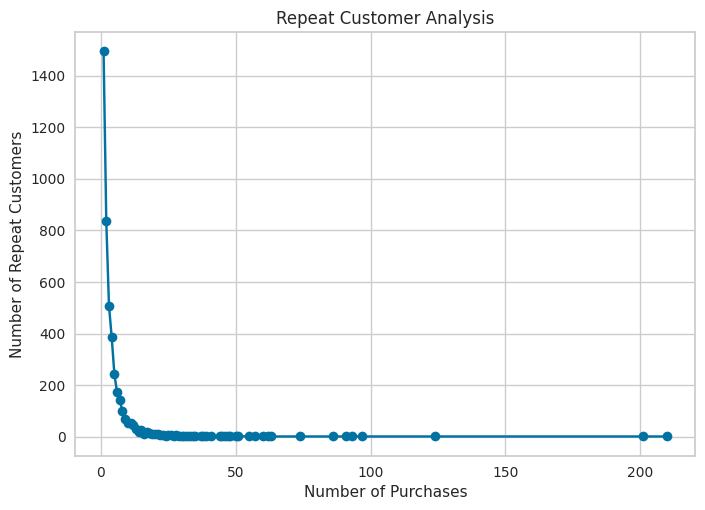

In [ ]:
# Grouping data by CustomerID and counting the number of purchases
customer_purchase_count = data.groupby('CustomerID')['InvoiceNo'].nunique()

# Counting the number of repeat customers for each purchase count
repeat_customer_count = customer_purchase_count.value_counts().sort_index()

# Creating a line chart for repeat customers
plt.plot(repeat_customer_count.index, repeat_customer_count.values, marker='o')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Repeat Customers')
plt.title('Repeat Customer Analysis')
plt.show()


## Count the number of items sold for each product for each period

In [ ]:
# Total items sold per month
monthly_item_sold = data.groupby(['Year', 'Month', 'Description'])['Quantity'].sum().reset_index()
monthly_item_sold.columns = ['Year', 'Month', 'Description', 'Total Quantity']

# Index with the largest total quantity per month
max_quantity_idx = monthly_item_sold.groupby(['Year', 'Month'])['Total Quantity'].idxmax()

# Top item per month
top_item_per_month = monthly_item_sold.loc[max_quantity_idx]
top_item_per_month


,Year,Month,Description,Total Quantity
2383,2010,12,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5139
3526,2011,1,MEDIUM CERAMIC TOP STORAGE JAR,74215
5147,2011,2,EMPIRE DESIGN ROSETTE,3986
7695,2011,3,JUMBO BAG RED RETROSPOT,4924
11070,2011,4,WORLD WAR 2 GLIDERS ASSTD DESIGNS,10224
13054,2011,5,SMALL POPCORN HOLDER,6738
14440,2011,6,JUMBO BAG RED RETROSPOT,3529
16588,2011,7,GIRLS ALPHABET IRON ON PATCHES,4896
18249,2011,8,ASSORTED COLOUR BIRD ORNAMENT,6425
21663,2011,9,JUMBO BAG RED RETROSPOT,4177


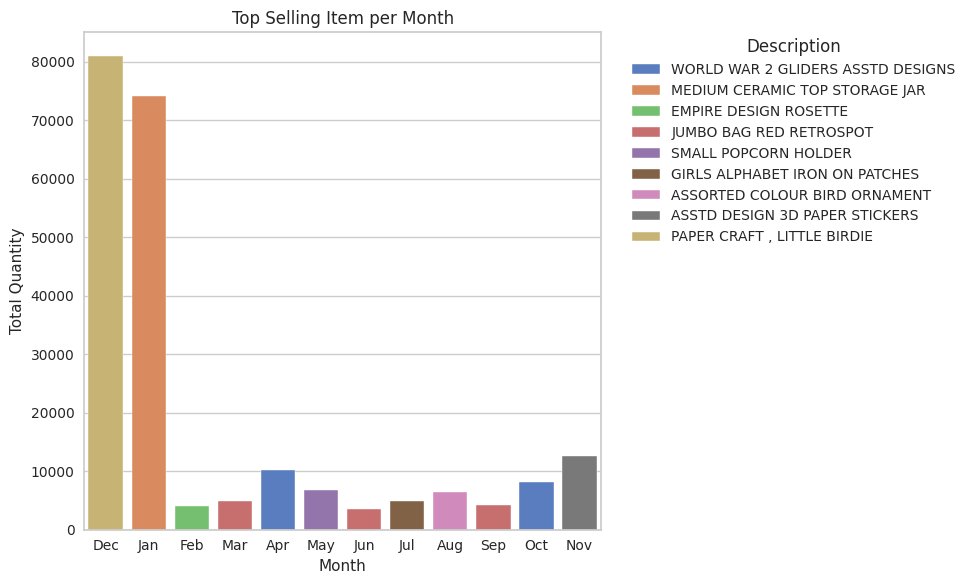

In [ ]:
# Create a dictionary to map month numbers to month names
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Map month numbers to month names in the 'Month' column
top_item_per_month['Month'] = top_item_per_month['Month'].map(month_map)

plt.figure(figsize=(10, 6))

# Draw bar chart using seaborn
sns.barplot(data=top_item_per_month, x='Month', y='Total Quantity', hue='Description', dodge=False, palette='muted')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.title('Top Selling Item per Month')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Description')

# Adjust plot layout to accommodate the legend
plt.tight_layout()

# Show the plot
plt.show()


### In what month the top 1 highest product?

Highest Selling Product:
Year                                     2011
Month                                     Dec
Description       PAPER CRAFT , LITTLE BIRDIE
Total Quantity                          80995
Name: 29751, dtype: object

Top 1 highest product In 'Dec' or '12st/nd/th' month and in year '2011'


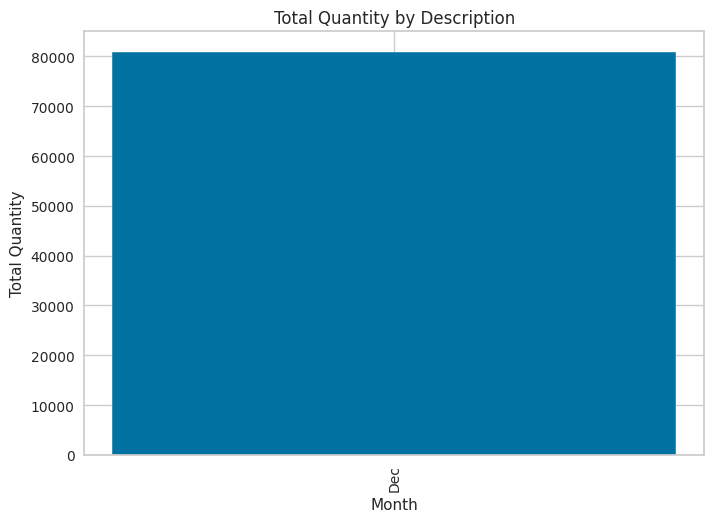

In [ ]:
# Melakukan filtering terhadap nomor index berdasarkan pencarian tertinggi 'Total Quantity'
max_index = top_item_per_month['Total Quantity'].idxmax()
# print(max_index)

# Mencari letak max_index pada 'top_item_per_month' dan mengambil informasi setiap kolom tersebut
filtered_row = top_item_per_month.loc[max_index]

# Fungsi untuk mendapatkan nomor bulan berdasarkan dictionary
def get_month_number(month_name):
    for key, value in month_map.items():
        if value == month_name:
            return key
    return None

print("Highest Selling Product:")
print(filtered_row)

month_name = filtered_row['Month']
month_number = get_month_number(month_name)

print(f"\nTop 1 highest product In '{month_name}' or '{month_number}st/nd/th' month and in year '{filtered_row['Year']}'")


plt.bar(x=filtered_row['Month'], height=filtered_row['Total Quantity'],label=filtered_row['Description'])
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.title('Total Quantity by Description')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Preparing RFMT Metrics

In [ ]:
# Unique CustomerID
print(f"Unique Customer ID: {data['CustomerID'].nunique()}")

# Check the last order date
print(f"Last order date: {data['InvoiceDate'].max()}")

# Observation period end
print(f"Observation period end is {data['Year'].max()}")

Unique Customer ID: 4339
Last order date: 2011-12-09 12:50:00
Observation period end is 2011


In [ ]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
rfmt_data = summary_data_from_transaction_data(transactions = df, 
                                         customer_id_col = 'CustomerID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'TotalSales')
rfmt_data.reset_index()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...,...
4334,18280.0,0.0,0.0,277.0,0.000000
4335,18281.0,0.0,0.0,180.0,0.000000
4336,18282.0,1.0,119.0,126.0,77.840000
4337,18283.0,13.0,334.0,337.0,152.802308


Recency: The recency variable is a measure of the time elapsed since the customer’s last purchase.
Frequency: The frequency corresponds to the number of orders placed by a customer.
Monetary: The monetary metric shows the total revenue generated by each customer.
Tenure: Tenure, or T, represents how long a given customer has been with the company.

## FINDING: "Pssst... there is a Customer with One Time Buy!"

The percentage of customer with one time buy is 35.7%


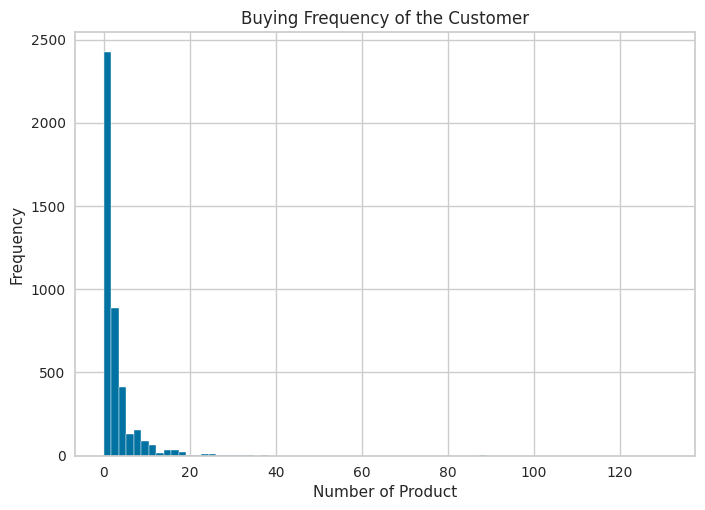

In [ ]:
# OneTimeBuyer_Percentage = (the sum of each customer with 0 frequency / the number of customer) * 100
one_time_buyer = round(sum(rfmt_data['frequency'] == 0)/float(len(rfmt_data))*(100),2)
print(f"The percentage of customer with one time buy is {one_time_buyer}%")

rfmt_data['frequency'].plot(kind='hist', bins=75)
plt.xlabel('Number of Product')
plt.title('Buying Frequency of the Customer');

As you can see, there is a big spike of frequency (number of customer) when x (number of product) is 0. This indicate there is a one time buyer customer, with the percentage of 35.7%.

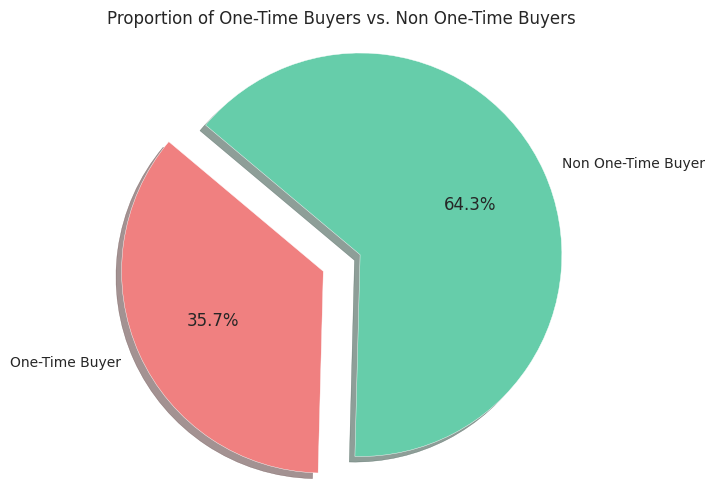

In [ ]:
# Calculate the proportion of One-Time Buyers
one_time_buyer_percentage = one_time_buyer
non_one_time_buyer_percentage = 100.0 - one_time_buyer_percentage

sizes = [one_time_buyer_percentage, non_one_time_buyer_percentage]
labels = ['One-Time Buyer', 'Non One-Time Buyer']
colors = ['lightcoral', 'mediumaquamarine']
explode = (0.2, 0)  # explode the One-Time Buyer slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Proportion of One-Time Buyers vs. Non One-Time Buyers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## BG/NBD Parameter Testing

In [ ]:
# Getting the ending date of the calibration period. 
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + ((df['InvoiceDate'].max() - df['InvoiceDate'].min()) - dt.timedelta(days=200))

In [ ]:
rfmt_data_calibration = calibration_and_holdout_data(transactions=df, 
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
rfmt_data_calibration.dropna(inplace=True)

In [ ]:
# Define a list of penalizer coefficients to test
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Initialize empty lists to store results
rmse_list = []

# Loop through each penalizer coefficient
for coef in l2_coefs:
    # Fit the BG/NBD model with the current penalizer coefficient
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(rfmt_data_calibration['frequency_cal'], 
              rfmt_data_calibration['recency_cal'], 
              rfmt_data_calibration['T_cal'])
    
    # Predict the frequency for the holdout period
    pred_freq = model.predict(rfmt_data_calibration['duration_holdout'], 
                              rfmt_data_calibration['frequency_cal'], 
                              rfmt_data_calibration['recency_cal'], 
                              rfmt_data_calibration['T_cal'])
    
    # Replace NaN values in pred_freq with zero
    pred_freq.fillna(0, inplace=True)

    # Compute the RMSE score
    rmse_score = np.sqrt(mean_squared_error(rfmt_data_calibration['frequency_holdout'], pred_freq))

    # Append results to the lists
    rmse_list.append(rmse_score)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'L2 coefs': l2_coefs, 'rmse_score': rmse_list})

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arra

In [ ]:
def get_best_penalty(results_df):
    sorted_results = results_df.sort_values(by='rmse_score')
    best_penalty = sorted_results.iloc[0]['L2 coefs']
    
    # Return the penalizer coefficient and its corresponding RMSE score as a dictionary
    best_penalty_dict = {best_penalty: sorted_results.iloc[0]['rmse_score']}
    
    return best_penalty_dict

best_penalty_dict = get_best_penalty(results_df)

# Get key from best_penalty_dict:
best_penalizer_coef = list(best_penalty_dict.keys())[0]
print(results_df)
print("-----------------------")
print(f"Best penalizer_coef is {best_penalizer_coef}")


   L2 coefs  rmse_score
0       0.3    2.386897
1       0.4    2.382149
2       0.5    2.377603
3       0.6    2.376416
4       0.7    2.374807
5       0.8    2.374072
6       0.9    2.374166
7       1.0    2.372444
-----------------------
Best penalizer_coef is 1.0


##  BG/NBD model fit

Frequency or Recency analysis using BG/NBD model.

<img src="image-20240506-160238.png" width="" align="" />

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=best_penalizer_coef)
bgf.fit(rfmt_data['frequency'], 
        rfmt_data['recency'], 
        rfmt_data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 25.82, b: 0.00, r: 0.32>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.167571e-01,6.071378e-03,3.048572e-01,3.286570e-01
alpha,2.581814e+01,8.793441e-01,2.409463e+01,2.754166e+01
a,1.189592e-18,3.045517e-13,-5.969202e-13,5.969226e-13
b,3.053484e-08,7.810393e-03,-1.530834e-02,1.530840e-02


## Metrics Analysis

### Frequency of Repeat Transactions

<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

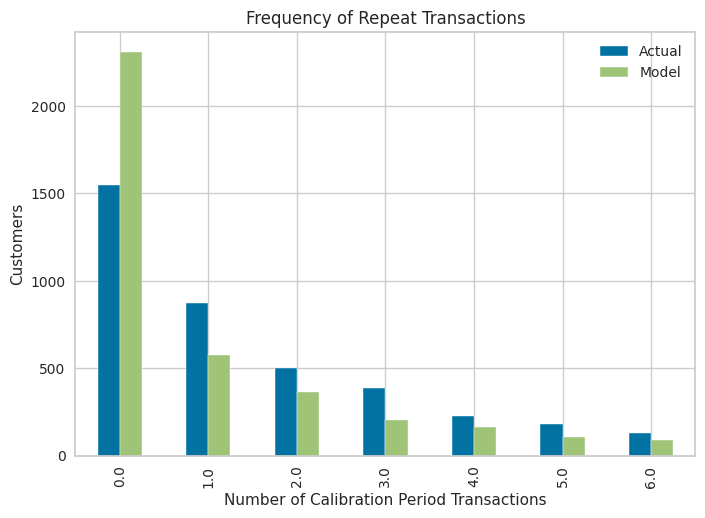

In [ ]:
plot_period_transactions(bgf)

### Probability Alive Matrix

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

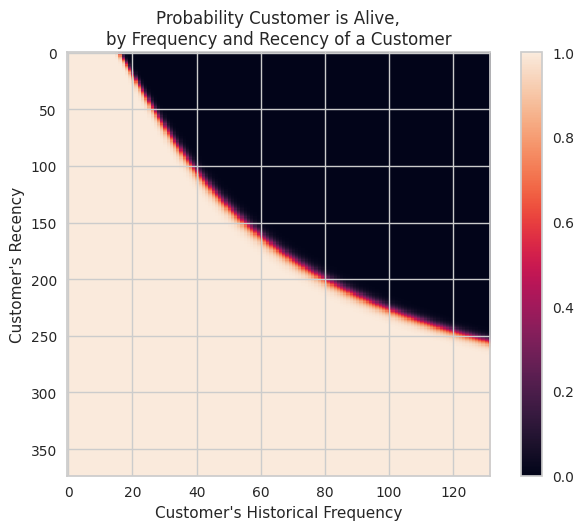

In [ ]:
plot_probability_alive_matrix(bgf) 

### Frequency and Recency Matrix

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

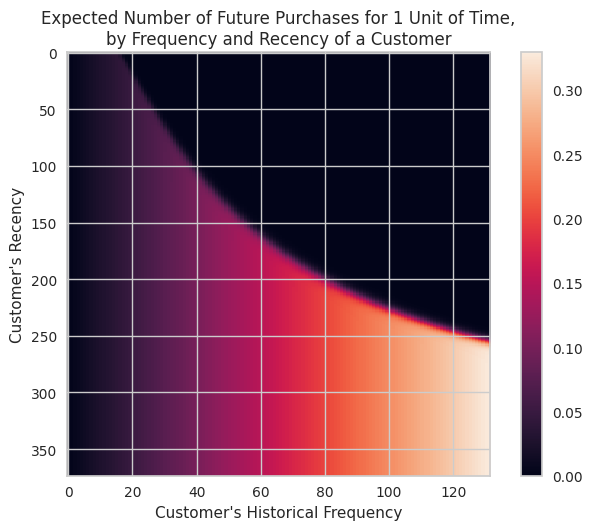

In [ ]:
plot_frequency_recency_matrix(bgf)

### Calibration Purchases vs Holdout Purchases

In [ ]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=best_penalizer_coef)
model.fit(rfmt_data_calibration['frequency_cal'], 
        rfmt_data_calibration['recency_cal'], 
        rfmt_data_calibration['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2868 subjects, a: 0.00, alpha: 20.94, b: 0.00, r: 0.27>

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

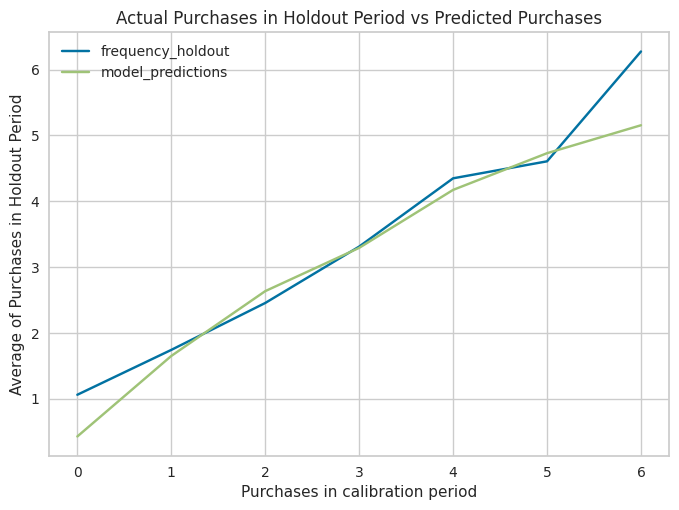

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(model, rfmt_data_calibration)

We can inspect the performance of the model visually using the method “plot_calibration_purchases_vs_holdout_purchases” which compares the predicted purchases(the frequency values predicted by the model) to the holdout purchases (the frequency values not seen by the model).

# Predicting the next three months of Purchases and Monetary Value for each customer

## Predicting the Expected Number of Purchase for each Customer

In [ ]:
# Predicting the number of purchases in the next 90 days for all customers.
rfmt_data['expected_purchases_3_months'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(90, 
                                                                                      rfmt_data['frequency'], 
                                                                                      rfmt_data['recency'], 
                                                                                      rfmt_data['T']),2)

# Getting rid of negative values.
rfmt_data = rfmt_data[rfmt_data['monetary_value']>0]
rfmt_data

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,expected_purchases_3_months
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.45
12348.0,3.0,283.0,358.0,301.480000,0.78
12352.0,6.0,260.0,296.0,368.256667,1.77
12356.0,2.0,303.0,325.0,269.905000,0.59
12358.0,1.0,149.0,150.0,683.200000,0.67
...,...,...,...,...,...
18272.0,5.0,244.0,246.0,487.752000,1.76
18273.0,2.0,255.0,257.0,76.500000,0.74
18282.0,1.0,119.0,126.0,77.840000,0.78


In [ ]:
frequency_monetary_corr = rfmt_data[['frequency', 'monetary_value']].corr()

print("Correlation between Frequency and Monetary Value:")
print(frequency_monetary_corr)

Correlation between Frequency and Monetary Value:
                frequency  monetary_value
frequency        1.000000        0.015882
monetary_value   0.015882        1.000000


## Gamma-Gamma model

This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

In [ ]:
# Fitting the GammaGamma model 
ggf = GammaGammaFitter(penalizer_coef=best_penalizer_coef)
rfmt_data = rfmt_data[rfmt_data['monetary_value']>0]
ggf.fit(rfmt_data['frequency'], rfmt_data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 0.32, q: 0.12, v: 0.24>

In [ ]:
rfmt_data = rfmt_data[rfmt_data['monetary_value']>0]
rfmt_data['expected_monetary_3_months'] = ggf.conditional_expected_average_profit(
        rfmt_data['frequency'],
        rfmt_data['monetary_value'])

rfmt_data = rfmt_data[rfmt_data['expected_monetary_3_months']>0]        
rfmt_data

,frequency,recency,T,monetary_value,expected_purchases_3_months,expected_monetary_3_months
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.45,1103.243634
12348.0,3.0,283.0,358.0,301.480000,0.78,3456.937880
12352.0,6.0,260.0,296.0,368.256667,1.77,677.493209
12359.0,3.0,274.0,331.0,1941.693333,0.84,22259.563253
12362.0,9.0,292.0,295.0,527.458889,2.61,758.159866
...,...,...,...,...,...,...
18245.0,4.0,348.0,355.0,550.332500,1.02,1744.923516
18257.0,6.0,257.0,296.0,334.871667,1.77,616.080442
18260.0,5.0,186.0,358.0,482.500000,1.25,1066.781512


# Predicting CLV - 3 Months

Predicting CLV for the next three months for each customer using "customer_life_time" method.

In [ ]:
# Predicting the CLV.
rfmt_data['CLV_3_months'] = round(ggf.customer_lifetime_value(
    bgf,
    rfmt_data['frequency'],
    rfmt_data['recency'],
    rfmt_data['T'],
    rfmt_data['monetary_value'],
    time = 3,# In months 
    ), 2)
rfmt_data 

,frequency,recency,T,monetary_value,expected_purchases_3_months,expected_monetary_3_months,CLV_3_months
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.45,1103.243634,1565.27
12348.0,3.0,283.0,358.0,301.480000,0.78,3456.937880,2635.69
12352.0,6.0,260.0,296.0,368.256667,1.77,677.493209,1173.28
12359.0,3.0,274.0,331.0,1941.693333,0.84,22259.563253,18255.66
12362.0,9.0,292.0,295.0,527.458889,2.61,758.159866,1942.59
...,...,...,...,...,...,...,...
18245.0,4.0,348.0,355.0,550.332500,1.02,1744.923516,1745.14
18257.0,6.0,257.0,296.0,334.871667,1.77,616.080442,1066.93
18260.0,5.0,186.0,358.0,482.500000,1.25,1066.781512,1303.80


# Customer Segmentation - KMeans Algorithm

## Preparing the data

In [ ]:
kmeans_data = rfmt_data[['expected_monetary_3_months', 'CLV_3_months']].copy()

kmeans_data

,expected_monetary_3_months,CLV_3_months
CustomerID,,
12347.0,1103.243634,1565.27
12348.0,3456.937880,2635.69
12352.0,677.493209,1173.28
12359.0,22259.563253,18255.66
12362.0,758.159866,1942.59
...,...,...
18245.0,1744.923516,1745.14
18257.0,616.080442,1066.93
18260.0,1066.781512,1303.80


## Model Fit

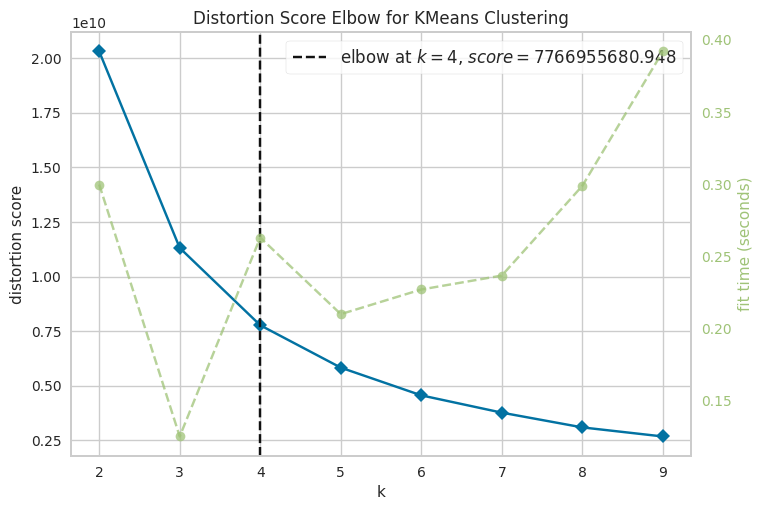

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# # Normalize the data
# scaler = StandardScaler()
# normalized_data = scaler.fit_transform(kmeans_data[['CLV_3_months']])

# Instantiate KMeans model
kmeans_model = KMeans()

# Instantiate the KElbowVisualizer with the kmeans model and the metric
visualizer = KElbowVisualizer(kmeans_model, k=(2, 10))

# Fit the visualizer to the normalized data
visualizer.fit(rfmt_data)

# Finalize and display the figure
visualizer.show()

In [ ]:
# Perform KMeans clustering, k=4
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(rfmt_data)

# Add cluster labels to the DataFrame
rfmt_data['cluster'] = kmeans_model.labels_

# View the clusters
rfmt_data

,frequency,recency,T,monetary_value,expected_purchases_3_months,expected_monetary_3_months,CLV_3_months,cluster
CustomerID,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,1.45,1103.243634,1565.27,1
12348.0,3.0,283.0,358.0,301.480000,0.78,3456.937880,2635.69,1
12352.0,6.0,260.0,296.0,368.256667,1.77,677.493209,1173.28,1
12359.0,3.0,274.0,331.0,1941.693333,0.84,22259.563253,18255.66,0
12362.0,9.0,292.0,295.0,527.458889,2.61,758.159866,1942.59,1
...,...,...,...,...,...,...,...,...
18245.0,4.0,348.0,355.0,550.332500,1.02,1744.923516,1745.14,1
18257.0,6.0,257.0,296.0,334.871667,1.77,616.080442,1066.93,1
18260.0,5.0,186.0,358.0,482.500000,1.25,1066.781512,1303.80,1


In [ ]:
rfmt_data['cluster'].unique()

array([1, 0, 2, 3], dtype=int32)

In [ ]:
# Grouping by clusters
df_clusters = rfmt_data.groupby(['cluster'])['CLV_3_months']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters

,cluster,avg_CLV,n_customers,perct_customers
0,0,20167.875517,29,2.049470
1,1,1663.615427,1183,83.604240
2,2,7145.471558,199,14.063604
3,3,58569.527500,4,0.282686


In [ ]:
rfmt_data['customer_category'] = rfmt_data['cluster']\
.replace({3:"Silver", 1:"Bronze", 2:"Gold", 0:"Diamond"})

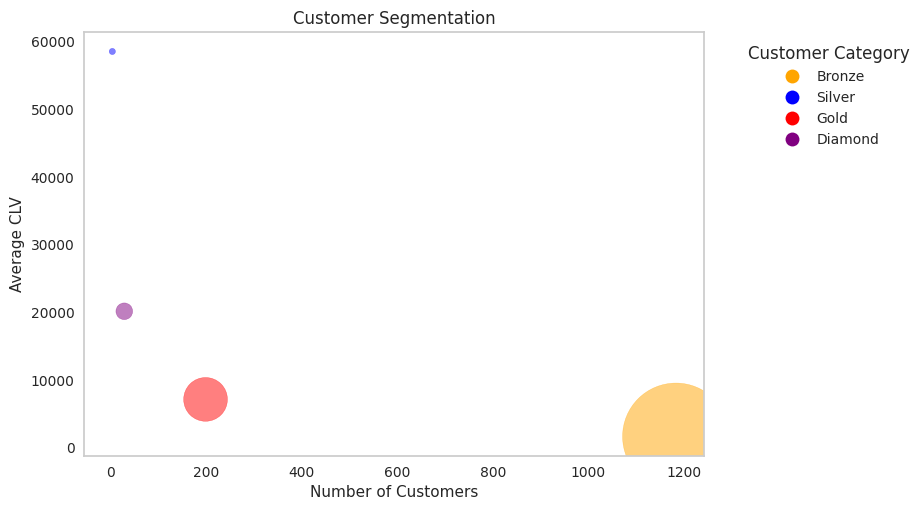

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each customer category
color_map = {'Bronze': 'orange', 'Silver': 'blue', 'Gold': 'red', 'Diamond': 'purple'}

# Map customer categories to colors for df_clusters
df_clusters['customer_category'] = df_clusters['cluster'].replace({3: 'Silver', 1: 'Bronze', 2: 'Gold', 0: 'Diamond'})
colors = df_clusters['customer_category'].map(color_map)

# Scatter plot with adjusted bubble sizes and colors
plt.scatter(df_clusters['n_customers'], df_clusters['avg_CLV'], s=df_clusters['n_customers']*5, alpha=0.5, c=colors)

# Remove horizontal and vertical gridlines
plt.grid(False)

# Add labels and title
plt.xlabel('Number of Customers')
plt.ylabel('Average CLV')
plt.title('Customer Segmentation')

# Create legend handles and labels
legend_handles = []
legend_labels = []
for category, color in color_map.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    legend_labels.append(category)

# Add legend outside the plot
plt.legend(legend_handles, legend_labels, title='Customer Category', loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()


### Customer Segmentation Category

In [ ]:
avg_customer_category = rfmt_data.groupby('customer_category').mean().reset_index()
avg_customer_category.drop(columns='cluster', inplace=True)

avg_customer_category

,customer_category,frequency,recency,T,monetary_value,expected_purchases_3_months,expected_monetary_3_months,CLV_3_months
0,Bronze,7.346577,274.158918,306.486898,353.033327,2.119958,1050.369063,1663.615427
1,Diamond,11.896552,215.827586,235.241379,1743.082856,3.662414,10990.219072,20167.875517
2,Gold,7.055276,226.160804,263.708543,779.370708,2.231759,5383.903664,7145.471558
3,Silver,27.750000,294.000000,297.250000,6798.076967,8.477500,7619.310711,58569.527500


### Top 10 Customer's CLV

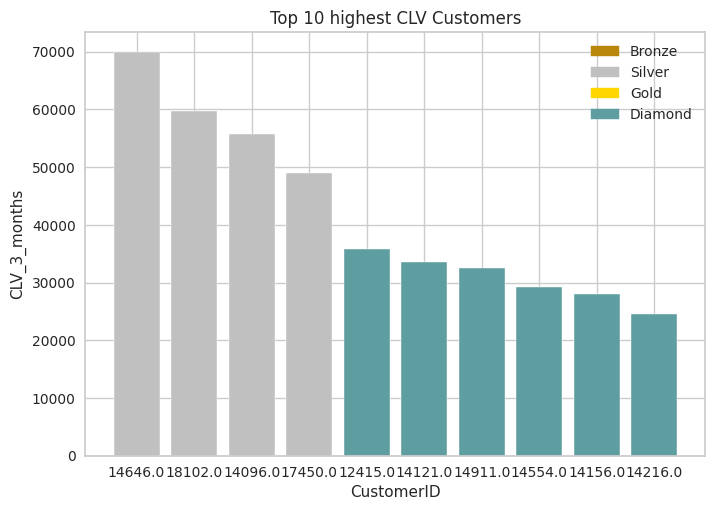

  CustomerID  CLV_3_months customer_category
0    14646.0      69891.94            Silver
1    18102.0      59703.54            Silver
2    14096.0      55761.75            Silver
3    17450.0      48920.88            Silver
4    12415.0      35815.21           Diamond
5    14121.0      33582.59           Diamond
6    14911.0      32450.20           Diamond
7    14554.0      29162.32           Diamond
8    14156.0      28052.12           Diamond
9    14216.0      24560.47           Diamond


In [ ]:
import matplotlib.patches as mpatches

top_10 = rfmt_data.nlargest(10, 'CLV_3_months')
top_10.reset_index(inplace=True)
top_10_clv = top_10[['CustomerID', 'CLV_3_months', 'customer_category']]

# Define a color map based on the unique values of 'customer_category'
color_map = {'Bronze': 'darkgoldenrod', 'Silver': 'silver', 'Gold': 'gold', 'Diamond': 'cadetblue'}

# Use bar plot instead of barplot
bars = plt.bar(top_10_clv['CustomerID'], top_10_clv['CLV_3_months'], color=top_10_clv['customer_category'].map(color_map))

# Create custom legend handles
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

# Add legend
plt.legend(handles=legend_handles)

# Add titles and labels
plt.title("Top 10 highest CLV Customers")
plt.xlabel("CustomerID")
plt.ylabel("CLV_3_months")

plt.show()

print(top_10_clv)

## 3 Months of CLV Prediction Analysis

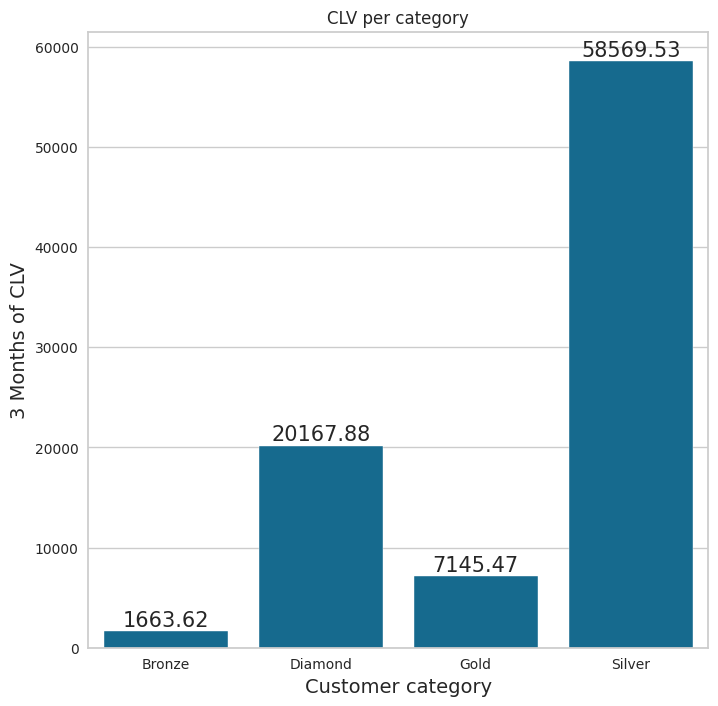

In [ ]:
# Grouping by customer category
df_cat = pd.DataFrame(rfmt_data.groupby(['customer_category'])['CLV_3_months']\
                      .agg('mean')).reset_index()

plt.figure(figsize=(8, 8))
 
plots = sns.barplot(x="customer_category", y="CLV_3_months", data=df_cat)
 
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("3 Months of CLV", size=14)
 
# Setting the title for the graph
plt.title("CLV per category")
 
# Finally showing the plot
plt.show()

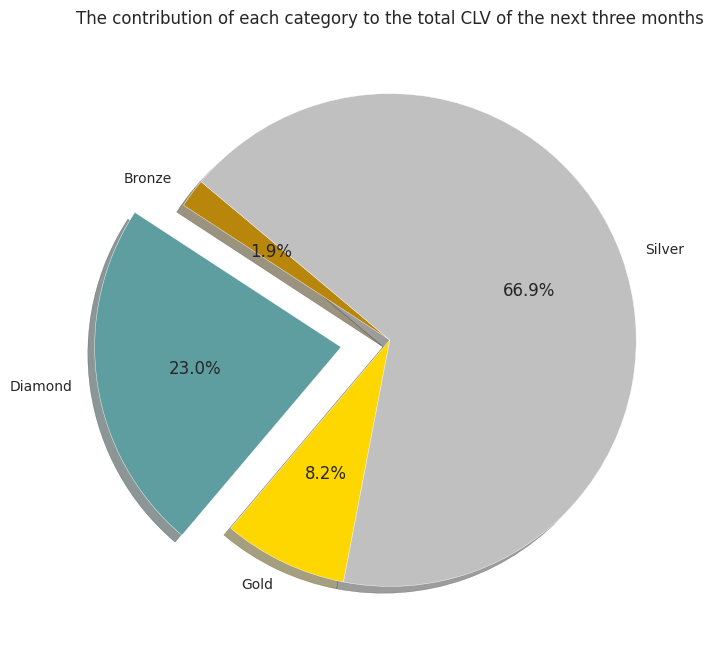

In [ ]:
import matplotlib.pyplot as plt

# Define custom colors for each customer category
custom_colors = {'Bronze': 'darkgoldenrod', 'Silver': 'silver', 'Gold': 'gold', 'Diamond': 'cadetblue'}

# Calculate contribution to CLV as percentages
df_cat["contribution_to_CLV"] = df_cat['CLV_3_months'] / df_cat['CLV_3_months'].sum() * 100

# Define explode parameter (0.2 for "Diamond", 0 for others)
explode = [0.2 if category == "Diamond" else 0 for category in df_cat["customer_category"]]

# Create pie chart
plt.figure(figsize=(8, 8))

# Pie chart configuration with custom colors and explode parameter
plt.pie(df_cat["contribution_to_CLV"], labels=df_cat["customer_category"], autopct='%1.1f%%', startangle=140, shadow=True, colors=[custom_colors[category] for category in df_cat["customer_category"]], explode=explode)

# Title for the pie chart
plt.title("The contribution of each category to the total CLV of the next three months")

# Show the plot
plt.show()


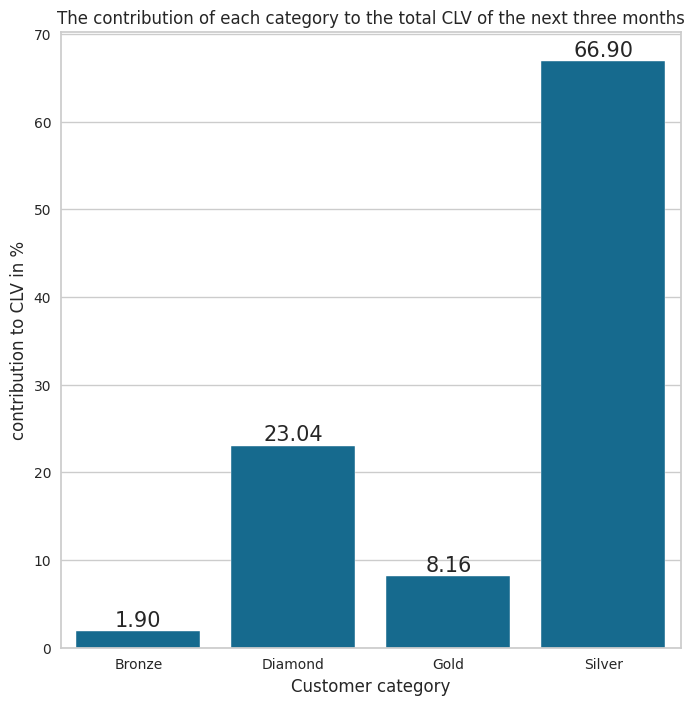

In [ ]:
df_cat["contribution_to_CLV"] = df_cat['CLV_3_months']/df_cat['CLV_3_months'].sum()*100

plt.figure(figsize=(8, 8))

plots = sns.barplot(x="customer_category", y="contribution_to_CLV", data=df_cat)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=12)

# Setting the label for y-axis
plt.ylabel("contribution to CLV in %", size=12)
 
# Setting the title for the graph
plt.title("The contribution of each category to the total CLV of the next three months")
 
# Finally showing the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6862784-1edd-41cc-8ccf-a184a726a01c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>